In [ ]:
# Loading libraries
import pandas as pd

import numpy as np
from numpy import mean
from numpy import std

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn import metrics 
from sklearn.model_selection import train_test_split 
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression

In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading datasets
train_df = pd.read_csv("/content/drive/MyDrive/CFG_Project/fraudTrain.csv")
test_df = pd.read_csv("/content/drive/MyDrive/CFG_Project/fraudTest.csv")

In [ ]:
# merging pre-split training and test datasets into one dataframe
df = train_df.append(test_df, ignore_index=True)

In [ ]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [ ]:
df.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [ ]:
#Removing irrelevant variables

irrelevantVar_list = ['Unnamed: 0', 
                      "trans_date_trans_time", 
                      "first", 
                      "last", 
                      "street", 
                      "lat", 
                      "job", 
                      "long",  
                      "cc_num", 
                      "trans_num", 
                      "city", 
                      "zip", 
                      "merchant", 
                      "merch_lat", 
                      "merch_long"]

df.drop(irrelevantVar_list, axis=1, inplace=True)

In [ ]:
df.head(5)

,category,amt,gender,state,city_pop,dob,unix_time,is_fraud
0,misc_net,4.97,F,NC,3495,1988-03-09,1325376018,0
1,grocery_pos,107.23,F,WA,149,1978-06-21,1325376044,0
2,entertainment,220.11,M,ID,4154,1962-01-19,1325376051,0
3,gas_transport,45.00,M,MT,1939,1967-01-12,1325376076,0
4,misc_pos,41.96,M,VA,99,1986-03-28,1325376186,0


In [ ]:
#First, I will use the code developed by Juliana to transform the date of birth column into numeric age

import datetime as dt
from datetime import time
from datetime import timedelta

yearCharacters = 4
currentYear = int(dt.datetime.now().strftime("%Y"))

df["dob"] = currentYear - df["dob"].str[:yearCharacters].astype(int)

In [ ]:
# Defining the feature columns that I will be feeding to the model 

feature_cols = ['dob', 'category', 'amt', 'gender', 'state', 'city_pop', 'unix_time']

In [ ]:
# Defining the input variables X as the feature columns and the target variable y as the label to predict

X = df[feature_cols] # Features
y = df.is_fraud # Target variable

In [ ]:
# Splitting dataset into training set and test set, the former will be 80% of the dataset and the latter 20%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
# here I am defining the type of transformation I want the column transformer to perform.
# I am specifying the categorical features 'category', 'gender' and 'state' as the targets for OneHotEncoder,
# while the remaining columns should pass through without being affected by the transformation

column_trans = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                        ['category', 'gender', 'state']), 
                                       remainder='passthrough')

In [ ]:
# Here I am defining the model and the pre-processing pipeline that will be applied to it.  

model = LogisticRegression()
pipe = make_pipeline(column_trans, model)

In [ ]:
# Fitting the model and pipeline by using input variables X and target variable y from the training set created previously
t_model = pipe.fit(X_train, y_train)
t_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category', 'gender',
                                                   'state'])])),
                ('logisticregression', LogisticRegression())])

In [ ]:
# Estabishing y_pred to use for the creation of a confusion matrix that evaluates the model

y_pred = t_model.predict(X_test)

In [ ]:
# Creating a confusion matrix as an array

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[368534,      0],
       [  1945,      0]])

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9947500398133228


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0
Recall: 0.0


Text(0.5, 257.44, 'Predicted label')

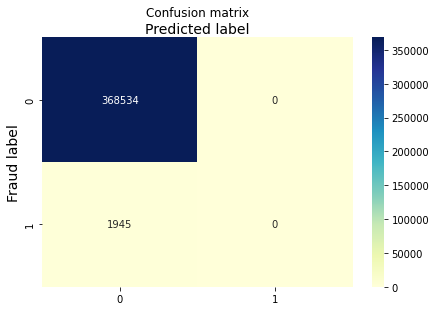

In [ ]:
# Showing confusion matrix as a heatmap
# Defining classes' names
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Creating heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Fraud label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
new_model = DecisionTreeClassifier()
new_pipe = make_pipeline(column_trans, new_model)

In [ ]:
# Train Decision Tree Classifer
new_t_model = new_pipe.fit(X_train, y_train)

In [ ]:
clf = new_t_model

In [ ]:
#Predict the response for test dataset
new_y_pred = new_t_model.predict(X_test)

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, new_y_pred)
cnf_matrix

array([[367894,    640],
       [   566,   1379]])

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, new_y_pred))
print("Precision:",metrics.precision_score(y_test, new_y_pred))
print("Recall:",metrics.recall_score(y_test, new_y_pred))

Accuracy: 0.9967447547634278
Precision: 0.683011391778108
Recall: 0.7089974293059126


Text(0.5, 257.44, 'Predicted label')

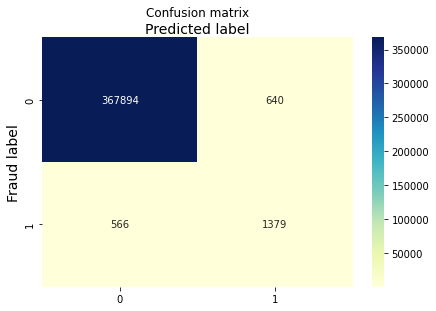

In [ ]:
# Showing confusion matrix as a heatmap

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Fraud label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)

In [ ]:
!pip install mlinsights

     |████████████████████████████████| 2.3 MB 5.1 MB/s 
     |████████████████████████████████| 126 kB 55.1 MB/s 


In [ ]:
!pip install pyquickhelper

     |████████████████████████████████| 2.2 MB 5.2 MB/s 
     |████████████████████████████████| 87 kB 5.1 MB/s 
  Created wheel for pyquicksetup: filename=pyquicksetup-0.2-py3-none-any.whl size=5989 sha256=364c20581e82f5f39e600adc7b2be41fdb31098e20e9b1652ddd556639dbd86a
  Stored in directory: /root/.cache/pip/wheels/31/6e/c1/e64bbd82aeaa823680f577081b69c84ae954c309af9911e007
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=1c8433a272321f6cbc3b92507a6dea33a8de9248ef733b7a921c53401bdc6255
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built pyquicksetup fire


In [ ]:
# creating logistic regression pre-processing and modelling visualisation
from mlinsights.plotting import pipeline2dot
dot = pipeline2dot(t_model, df)
print(dot)

digraph{
  orientation=portrait;
  nodesep=0.05;
  ranksep=0.25;
  sch0[label="<f0> category|<f1> amt|<f2> gender|<f3> state|<f4> city_pop|<f5> dob|<f6> unix_time|<f7> is_fraud",shape=record,fontsize=8];

  node1[label="union",shape=box,style="filled,rounded",color=cyan,fontsize=12];
  sch0:f0 -> node1;
  sch0:f2 -> node1;
  sch0:f3 -> node1;
  sch1[label="<f0> -v-0",shape=record,fontsize=8];
  node1 -> sch1:f0;

  node2[label="OneHotEncoder",shape=box,style="filled,rounded",color=cyan,fontsize=12];
  sch1:f0 -> node2;
  sch2[label="<f0> -v-1",shape=record,fontsize=8];
  node2 -> sch2:f0;

  node3[label="Identity",shape=box,style="filled,rounded",color=cyan,fontsize=12];
  sch0:f1 -> node3;
  sch0:f4 -> node3;
  sch0:f5 -> node3;
  sch0:f6 -> node3;
  sch0:f7 -> node3;
  sch3[label="<f0> -v-2|<f1> -v-3|<f2> -v-4|<f3> -v-5|<f4> -v-6",shape=record,fontsize=8];
  node3 -> sch3:f0;
  node3 -> sch3:f1;
  node3 -> sch3:f2;
  node3 -> sch3:f3;
  node3 -> sch3:f4;

  node4[label="union",shape=

In [ ]:
dot_file = "graph.dot"
with open(dot_file, "w", encoding="utf-8") as f:
    f.write(dot)

In [ ]:
from pyquickhelper.loghelper import run_cmd
cmd = "dot -G=300 -Tpng {0} -o{0}.png".format(dot_file)
run_cmd(cmd, wait=True, fLOG=print);

[run_cmd] execute dot -G=300 -Tpng graph.dot -ograph.dot.png
end of execution dot -G=300 -Tpng graph.dot -ograph.dot.png


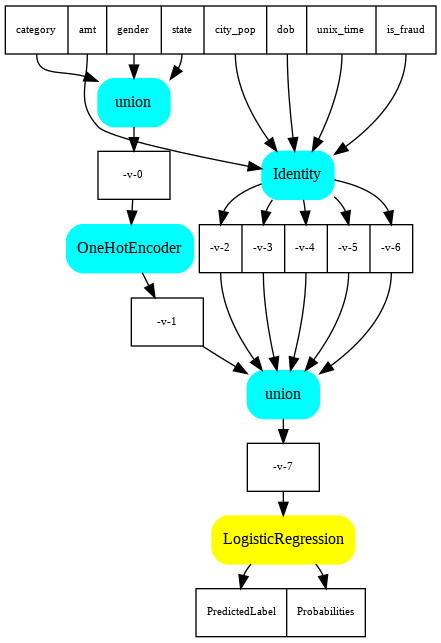

In [ ]:
from PIL import Image
img = Image.open("graph.dot.png")
img

In [ ]:
# creating decision tree pre-processing and modelling visualisation
from mlinsights.plotting import pipeline2dot
dot = pipeline2dot(clf, df)
print(dot)

digraph{
  orientation=portrait;
  nodesep=0.05;
  ranksep=0.25;
  sch0[label="<f0> category|<f1> amt|<f2> gender|<f3> state|<f4> city_pop|<f5> dob|<f6> unix_time|<f7> is_fraud",shape=record,fontsize=8];

  node1[label="union",shape=box,style="filled,rounded",color=cyan,fontsize=12];
  sch0:f0 -> node1;
  sch0:f2 -> node1;
  sch0:f3 -> node1;
  sch1[label="<f0> -v-0",shape=record,fontsize=8];
  node1 -> sch1:f0;

  node2[label="OneHotEncoder",shape=box,style="filled,rounded",color=cyan,fontsize=12];
  sch1:f0 -> node2;
  sch2[label="<f0> -v-1",shape=record,fontsize=8];
  node2 -> sch2:f0;

  node3[label="Identity",shape=box,style="filled,rounded",color=cyan,fontsize=12];
  sch0:f1 -> node3;
  sch0:f4 -> node3;
  sch0:f5 -> node3;
  sch0:f6 -> node3;
  sch0:f7 -> node3;
  sch3[label="<f0> -v-2|<f1> -v-3|<f2> -v-4|<f3> -v-5|<f4> -v-6",shape=record,fontsize=8];
  node3 -> sch3:f0;
  node3 -> sch3:f1;
  node3 -> sch3:f2;
  node3 -> sch3:f3;
  node3 -> sch3:f4;

  node4[label="union",shape=

In [ ]:
dot_file = "graph.dot"
with open(dot_file, "w", encoding="utf-8") as f:
    f.write(dot)

In [ ]:
from pyquickhelper.loghelper import run_cmd
cmd = "dot -G=300 -Tpng {0} -o{0}.png".format(dot_file)
run_cmd(cmd, wait=True, fLOG=print);

[run_cmd] execute dot -G=300 -Tpng graph.dot -ograph.dot.png
end of execution dot -G=300 -Tpng graph.dot -ograph.dot.png


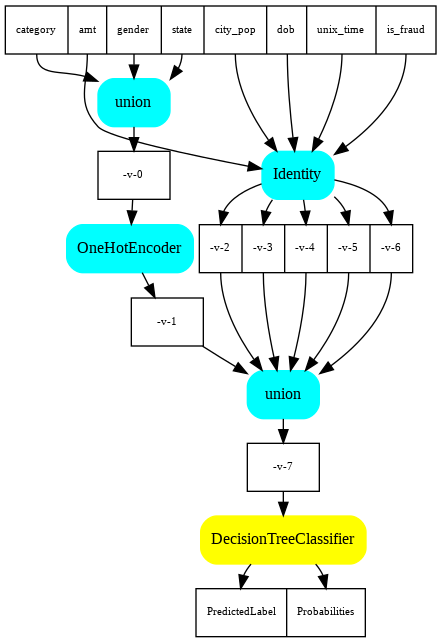

In [ ]:
from PIL import Image
img = Image.open("graph.dot.png")
img

I have successfully managed to create a pre-processing pipeline that employs OneHotEncoder to convert categorical data into numerical data. I have additionally applied the code developed by Juliana to convert the date of birth feature into a numerical value showing the age of the credit card holders.


First, I used the pre-processed dataset to train a logistic regression model. Unfortunately the results very clearly show that the model is currently prone to overfitting. Although its accuracy is extremely high, it can only correctly label genuine transactions, while it has labelled all fraudulent transactions incorrectly. Our aim is producing a model that is perhaps less accurate overall, however more often correctly identifies fraudulent transactions. The preferred outcome is sometimes flagging genuine transactions as suspicious, rather than labelling fradulent transactions as legitimate. The overfitting issue is very likely due to the unbalanced nature of the dataset, at the moment the model has an abudance of examples for genuine transactions, however it has very few opportunities to learn about the characteristics of fraudulent transactions. I need to test several techniques to see if there is a way to improve the performance of this model despite the unbalanced nature of the dataset.

I then tested a decision tree model with the same type of encoding. The performance is significantly better, with good metrics in accuracy, precision and recall scores. Specific accuracy in correctly labelling fraudulent transactions is 70%. While these results are very encouraging, decision tree models performance is often negatively impacted by OneHotEncoding, due to the added complications in dealing with sparse matrices. Juliana has been testing this model with a different type of encoding to see if it produces better results. 